# Experiment Notebook

In [18]:
import sys

import numpy as np
import pandas as pd

from src.fts_src import FinancialTimeSeriesSparseModel
from src.metrics import rmsre
from src.mesax import meSAX


from sklearn.model_selection import train_test_split

import yfinance as yf

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [3]:
ASSET_NAME = '^GSPC'
START_DATE = '2010-01-01'
END_DATE = '2020-01-01'
TRAIN_PROPORTION = 0.8

[*********************100%***********************]  1 of 1 completed


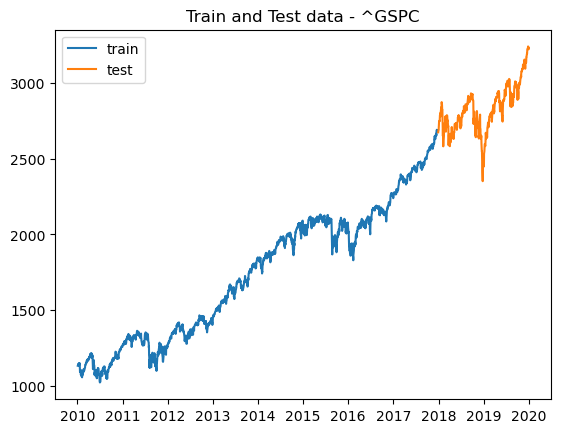

In [4]:
df = yf.download(ASSET_NAME, start=START_DATE, end=END_DATE)

# unpivot the dataframe by removing columns name
df = df.stack().reset_index()
df.columns.name = None
data = df.set_index('Date')[['Close']]
# train test split
train, test = train_test_split(data, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

# plot the train and test data
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Train and Test data - ' + ASSET_NAME)
plt.legend()
plt.show()

## m-eSAX representation

In [21]:
model = meSAX(K=6, windows_size=50, step_size=5, reconstruction_method="slope")
train_time_series = train.values.squeeze()
model.synthesize(train_time_series)
reconstructed_data = model.reconstruct()

3930it [00:00, 57185.33it/s]


In [24]:
reconstructed_data.shape

(19650,)

ValueError: x and y must have same first dimension, but have shapes (2012,) and (19650,)

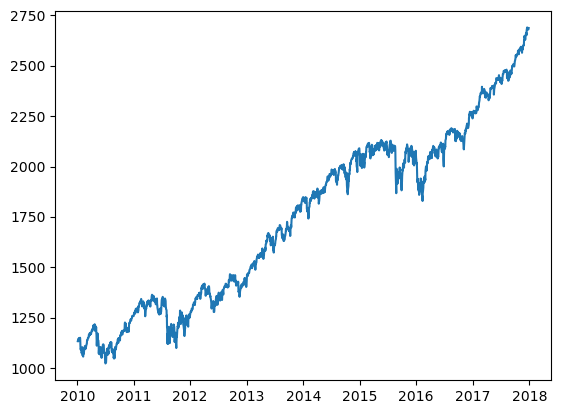

In [22]:
plt.plot(train.index, train_time_series, label='original')
plt.plot(train.index, reconstructed_data, label='reconstructed')

## Finanacial time series sparse representation coding (FT-SRC)

In [10]:
dict_atoms_number = 20
non_zero_coeff = 4
sliding_window_size = 30
sliding_window_stride = 10
max_iter = 100

In [11]:
model = FinancialTimeSeriesSparseModel(
    n_components=dict_atoms_number,
    n_nonzero_coefs=non_zero_coeff,
    window_size=sliding_window_size,
    stride=sliding_window_stride,
    max_iter=max_iter
)

In [12]:
train_time_series = train.values.squeeze()
model.fit(train_time_series)

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] ....................................................................................................
[*] Transforming the segmented data into sparse codes...


DictionaryLearning(max_iter=100, n_components=20, transform_max_iter=100,
                   transform_n_nonzero_coefs=4, verbose=True)

Compression ratio: 7.5
RMSRE: 0.00584022065505783


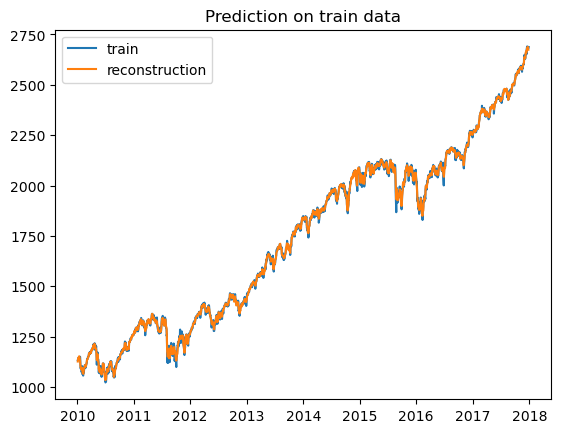

In [13]:
prediction, compression_ratio = model.predict(train_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))

plt.plot(train.index, train_time_series, label='train')
plt.plot(train.index, prediction, label='reconstruction')
plt.title('Prediction on train data')
plt.legend()

Compression ratio: 7.5
RMSRE: 0.006631597460967826


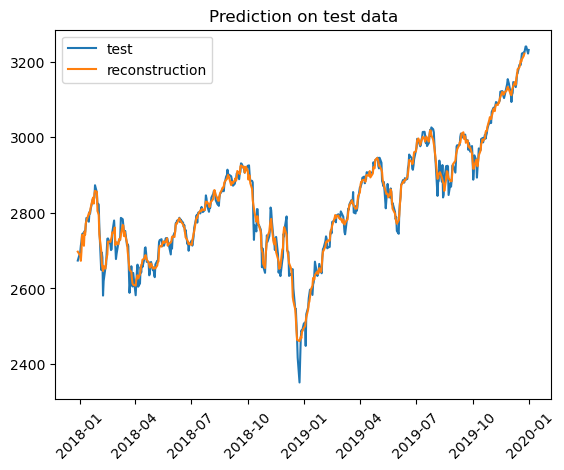

In [14]:
test_time_series = test.to_numpy()[:,0]
prediction, compression_ratio = model.predict(test_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(test_time_series, prediction))

plt.plot(test.index, test_time_series, label='test')
plt.plot(test.index, prediction, label='reconstruction')
plt.title('Prediction on test data')
plt.xticks(rotation=45)
plt.legend()